In [11]:
import numpy as np
import matplotlib.pyplot as plt
from pyuvdata import UVCal
import glob
from hera_qm import ant_metrics
%matplotlib inline 

# Examine Ant_Metrics

In [12]:
json_files = glob.glob('./test_data/*2457801*.json') 
ams = {int(jfile.split('.')[3]): ant_metrics.load_antenna_metrics(jfile) for jfile in json_files}
times = sorted(ams.keys())
antpols = ams.values()[0]['final_metrics']['meanVij'].keys()

In [13]:
removed = {antpol: [antpol in ams[t]['xants'] for t in times] for antpol in antpols}
dead = {antpol: [antpol in ams[t]['dead_ants'] for t in times] for antpol in antpols}
crossed = {antpol: [antpol in ams[t]['crossed_ants'] for t in times] for antpol in antpols}
print 'ant \t\tdead \tcrossed\tremoved'
for antpol in antpols:
    print antpol, '\t',np.sum(dead[antpol]), '\t', np.sum(crossed[antpol]), '\t', np.sum(removed[antpol])#100*np.mean(removed[antpol]), '%'

ant 		dead 	crossed	removed
(104, 'x') 	72 	0 	72
(97, 'y') 	0 	0 	0
(72, 'y') 	0 	0 	0
(65, 'x') 	0 	0 	0
(20, 'y') 	0 	0 	0
(96, 'x') 	0 	20 	20
(89, 'y') 	0 	0 	0
(64, 'y') 	0 	0 	0
(22, 'x') 	2 	70 	72
(10, 'x') 	0 	0 	0
(88, 'x') 	0 	0 	0
(43, 'y') 	0 	0 	0
(81, 'y') 	0 	72 	72
(80, 'y') 	0 	0 	0
(31, 'x') 	0 	0 	0
(80, 'x') 	0 	0 	0
(9, 'y') 	2 	1 	3
(112, 'y') 	0 	0 	0
(105, 'x') 	0 	0 	0
(97, 'x') 	0 	0 	0
(72, 'x') 	0 	0 	0
(53, 'x') 	0 	0 	0
(65, 'y') 	0 	0 	0
(104, 'y') 	72 	0 	72
(20, 'x') 	0 	0 	0
(22, 'y') 	1 	70 	71
(64, 'x') 	0 	0 	0
(96, 'y') 	0 	20 	20
(89, 'x') 	0 	0 	0
(10, 'y') 	0 	0 	0
(88, 'y') 	0 	0 	0
(31, 'y') 	0 	0 	0
(81, 'x') 	0 	72 	72
(112, 'x') 	0 	0 	0
(105, 'y') 	0 	0 	0
(43, 'x') 	0 	0 	0
(9, 'x') 	1 	1 	2
(53, 'y') 	0 	0 	0


In [14]:
print np.array(times)[(1-np.array(removed[(22, 'y')])).astype(bool)]
print ams[57060]['final_mod_z_scores']['redCorrXPol'][(22,'y')]
print ams[57060]['final_mod_z_scores']['meanVijXPol'][(22,'y')]

print np.min(np.abs([ams[t]['final_mod_z_scores']['redCorrXPol'][(22,'y')] for t in times])/2 + np.abs([ams[t]['final_mod_z_scores']['meanVijXPol'][(22,'y')]/2 for t in times])/2)

[57060]
10.4305470891
5.22374110016
5.71276289006


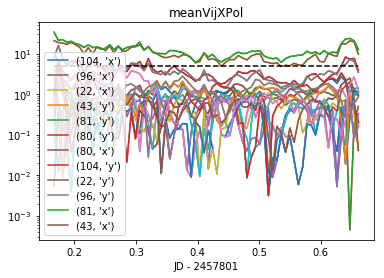

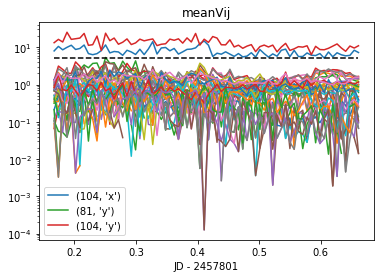

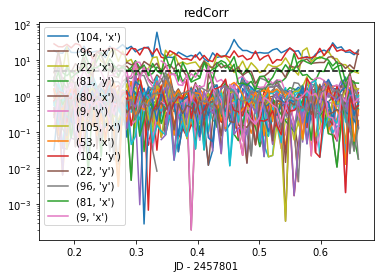

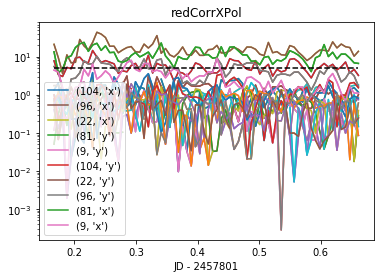

In [15]:
for plottype in ['meanVijXPol', 'meanVij', 'redCorr', 'redCorrXPol']:
    plt.figure()
    for antpol in antpols:
        toplot = np.abs([ams[t]['final_mod_z_scores'][plottype][antpol] for t in times])
        if np.any(toplot > 5):
            plt.semilogy(np.array(times)/1e5, toplot, label=antpol)
        else:
            plt.semilogy(np.array(times)/1e5, toplot)
    plt.legend()
    plt.title(plottype)
    plt.plot(np.array(times)/1e5, 5*np.ones_like(toplot),'k--')
    plt.xlabel('JD - 2457801')

# Examine Firstcal

In [16]:
fc_files = glob.glob('./test_data/*2457801*.calfits') 
allUVs = {(int(fc_file.split('.')[3]), fc_file.split('.')[4][0]): UVCal() for fc_file in fc_files}
for fc_file in fc_files:
    allUVs[(int(fc_file.split('.')[3]), fc_file.split('.')[4][0])].read_calfits(fc_file)

In [17]:
delays_byfile = {antpol: {} for antpol in antpols}
times_byfile = {}
for t in times:
    for (ant,pol) in antpols:
        UV = allUVs[(t,pol)]
        index = np.where(UV.ant_array == ant)[0]
        if len(index) == 0:
            delays_byfile[(ant,pol)][t] = [np.nan for i in range(UV.delay_array.shape[3])]
        elif len(index) == 1:
            delays_byfile[(ant,pol)][t] = (1e9*UV.delay_array[index[0],0,0,:,0])
    times_byfile[t]  = UV.time_array

In [18]:
delays = {antpol: np.array([]) for antpol in antpols}
int_times = []
for t in times:
    for (ant,pol) in antpols:
        UV = allUVs[(t,pol)]
        index = np.where(UV.ant_array == ant)[0]
        if len(index) == 0:
            delays[(ant,pol)] = np.append(delays[(ant,pol)],[np.nan for i in range(UV.delay_array.shape[3])])
        elif len(index) == 1:
            delays[(ant,pol)] = np.append(delays[(ant,pol)],(1e9*UV.delay_array[index[0],0,0,:,0]))
    int_times += list(UV.time_array)
int_times = np.array(int_times) - 2457801

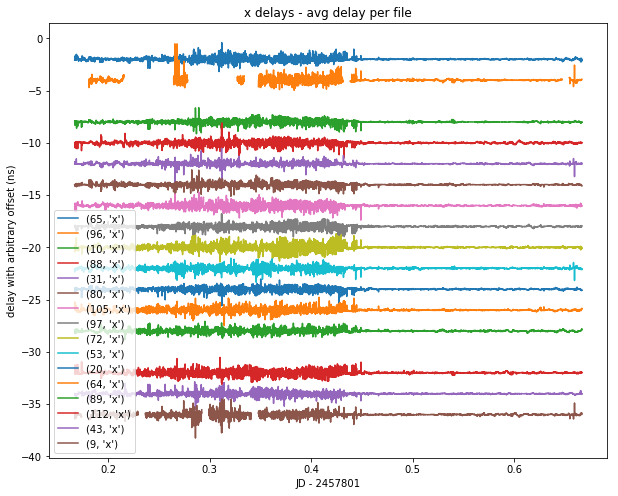

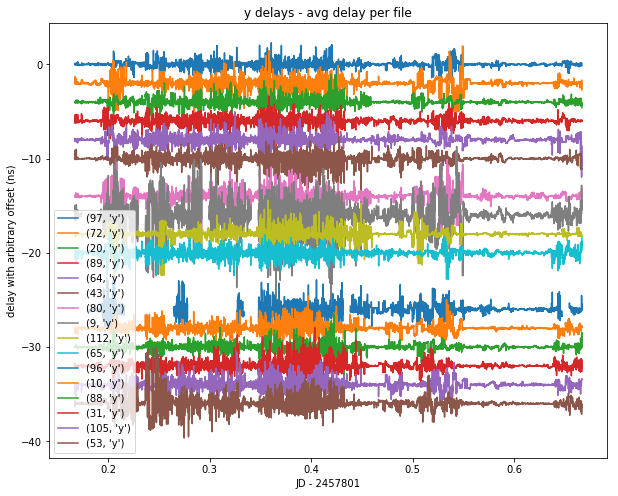

In [19]:
for p in ['x','y']:
    plt.figure(figsize=(10,8))
    for n,antpol in enumerate([(ant,pol) for (ant,pol) in antpols if pol is p]):
        toplot = [d for t in times for d in delays_byfile[antpol][t] - np.mean(delays_byfile[antpol][t])]
        if not np.all(np.isnan(toplot)):
            plt.plot(int_times, np.array(toplot) - 2*n, label=str(antpol))
    plt.legend()
    plt.title(p + ' delays - avg delay per file')
    plt.ylabel('delay with arbitrary offset (ns)')
    plt.xlabel('JD - 2457801')

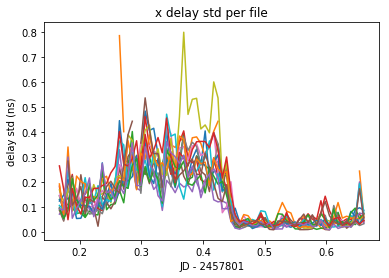

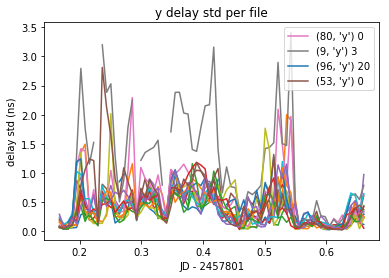

In [20]:
for p in ['x','y']:
    plt.figure()
    for antpol in antpols:
        if antpol[1] is p:
            #toplot = [d for t in times for d in delays_byfile[antpol][t] - np.mean(delays_byfile[antpol][t])]
            toplot = [np.std(delays_byfile[antpol][t]) for t in times]
            if not np.all(np.isnan(toplot)):
                if np.nanmean(toplot) > .5:
                    plt.plot(np.array(times)/1e5, toplot, label=str(antpol) + ' ' + str(np.sum(removed[antpol])))
                else:
                    plt.plot(np.array(times)/1e5, toplot)
        plt.legend()
    plt.title(p + ' delay std per file')
    plt.ylabel('delay std (ns)')
    plt.xlabel('JD - 2457801')